In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sn
from pickle import NONE
from gensim.models import Word2Vec

import nltk
from nltk.corpus import brown

emissionMat = []
transitionMat = []
startWords = []

alpha = 0.4

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [17]:
x = brown.tagged_sents(tagset='universal')
sentenceCount = len(x)  # Total number of sentences

# tags = [j[1] for i in x for j in i]
# words = [j[0] for i in x for j in i]

sentences = []
for i in x:
  sentence = []
  for j in i:
    sentence.append(j[0])
  sentences.append(sentence)

model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4, sg=1)


In [26]:
np.random.seed(10)
vector = np.random.rand(100)
model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[('Goddammit', 0.17963173985481262),
 ('Sulfaquinoxaline', 0.1715535670518875),
 ('Festivals', 0.16897553205490112),
 ('Autocollimator', 0.16675546765327454),
 ('used', 0.16313967108726501),
 ('by', 0.15168045461177826),
 ('Dairy', 0.1512501835823059),
 ('an', 0.13840442895889282),
 ('Repayment', 0.13808000087738037),
 ('This', 0.13627415895462036)]

In [25]:
def viterbi(trainSentences, sentences):
    global emissionMat, transitionMat, startWords, alpha, uniqueWords, uniqueTags, mapWords, mapTags
    wordCount = len(uniqueWords)
    tagCount = len(uniqueTags)
    tagList = []
    a = time.time()

    model1 = Word2Vec(trainSentences, size=100, window=5, min_count=1, workers=4, sg=1)
    model2 = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4, sg=1)

    probTagsToWords = (tagsToWords + alpha)/(tagsToWords.sum(axis=1, keepdims=True) + alpha*wordCount)
    probTagsToTags = (tagsToTags + alpha)/(tagsToTags.sum(axis=1, keepdims=True) + alpha*tagCount)

    tagCounts = tagsToTags.sum(axis = 1)

    for sentence in sentences:
        L = len(sentence)
        probTagSeq = np.zeros((L, tagCount))
        pred = np.zeros((L, tagCount))
        sentenceTags = np.zeros(L, dtype = np.int64)

        for i in range(0, L):
            wordin = mapWords.get(sentence[i])
            if (i == 0):
                for tag in uniqueTags:
                    tagin = mapTags[tag]
                    emissionProb = 0
                    transitionProb = 0
                    if (wordin):
                        emissionProb = probTagsToWords[tagin][wordin]
                    else:
                        wordvec = model2.wv[sentence[i]]
                        wordInVocab = model1.wv.similar_by_vector(wordvec, topn=1, restrict_vocab=None)[0][0]
                        print(model1.wv.similar_by_vector(wordvec, topn=10, restrict_vocab=None))
                        print(sentence[i], wordInVocab)
                        wordin = mapWords.get(wordInVocab)
                        emissionProb = probTagsToWords[tagin][wordin]
                    transitionProb = startWords[tagin]/np.sum(startWords)
                    probTagSeq[i][tagin] = np.log(emissionProb) + np.log(transitionProb)
            else:
                for tag in uniqueTags:
                    tagin = mapTags[tag]
                    maxTag = 0
                    maxProb = -np.inf
                    for prevTag in uniqueTags:
                        tagind = mapTags[prevTag]
                        emissionProb = 0
                        transitionProb = 0
                        if (wordin):
                            emissionProb = probTagsToWords[tagin][wordin]
                        else:
                            wordvec = model2.wv[sentence[i]]
                            wordInVocab = model1.wv.similar_by_vector(wordvec, topn=10, restrict_vocab=None)[0][0]
                            print(model1.wv.similar_by_vector(wordvec, topn=10, restrict_vocab=None))
                            print(sentence[i], wordInVocab)
                            wordin = mapWords.get(wordInVocab)
                            emissionProb = probTagsToWords[tagin][wordin]
                        transitionProb = probTagsToTags[tagind][tagin]
                        if (np.log(emissionProb) + np.log(transitionProb) + probTagSeq[i-1][tagind] > maxProb):
                            maxProb = np.log(emissionProb) + np.log(transitionProb) + probTagSeq[i-1][tagind]
                            maxTag = tagind
                    pred[i][tagin] = maxTag
                    probTagSeq[i][tagin] = maxProb

        lastTag = 0
        maxProbability = -np.inf

        for tag in uniqueTags:
            tagin = mapTags[tag]
            if (probTagSeq[L-1][tagin] > maxProbability):
                maxProbability = probTagSeq[L-1][tagin]
                lastTag = tagin
                lastTag = int(lastTag)
        sentenceTags[L-1] = lastTag
        for j in range(L-1):
            lastTag = int(lastTag)
            lastTag = pred[L-1-j][lastTag]
            sentenceTags[L-2-j] = lastTag
        sentenceTags = list(sentenceTags)
        tagList.append(sentenceTags)
    return tagList

In [4]:
'''
Function for caculating F-Score given precision and recall
'''
def FScore(precision, recall, beta):
    fscore = ((1+beta*beta)*precision*recall)/(beta*beta*precision + recall)
    return fscore

In [14]:
'''
Extracting data
'''
x = brown.tagged_sents(tagset='universal')
sentenceCount = len(x)  # Total number of sentences

tags = [j[1] for i in x for j in i]
words = [j[0] for i in x for j in i]

lens = np.array([len(x) for x in words])

N = len(tags)
print("Total number of words :", len(tags))

uniqueWords = set(words)
uniqueWords = list(uniqueWords)
print("Number of unique words :", len(uniqueWords))

uniqueTags = set(tags)
uniqueTags = list(uniqueTags)
print("Unique tags :", uniqueTags)

wordCount = len(uniqueWords)  # Number of unique words
tagCount = len(uniqueTags)  # Number of unique tags

'''
Index of the word in list of unique words 
'''
mapWords = {}
for i in range(len(uniqueWords)):
    mapWords[uniqueWords[i]] = i

'''
Index of a tag in list of unique tags
'''
mapTags = {}
for i in range(len(uniqueTags)):
    mapTags[uniqueTags[i]] = i


'''
Creating folds
'''
lenOfFold = int(np.floor(sentenceCount/5))
foldIndices = [[0, lenOfFold],
               [lenOfFold, 2*lenOfFold],
               [2*lenOfFold, 3*lenOfFold],
               [3*lenOfFold, 4*lenOfFold],
               [4*lenOfFold, sentenceCount]]

perFoldTagsToWords = np.zeros((5, tagCount, wordCount), dtype=np.int64)
perFoldTagsToTags = np.zeros((5, tagCount, tagCount), dtype=np.int64)
perFoldStartWords = np.zeros((5, tagCount), dtype=np.int64)

'''
Calculate tag to tag and tag to word count for each fold
'''
for i in range(5):
    for j in range(foldIndices[i][0], foldIndices[i][1]):
        curSentence = x[j]
        perFoldStartWords[i][mapTags[curSentence[0][1]]] += 1
        for k in x[j]:
            indexOfWord = mapWords[k[0]]
            indexOfTag = mapTags[k[1]]
            perFoldTagsToWords[i][indexOfTag][indexOfWord] += 1

        columnSum = np.sum(perFoldTagsToTags, axis=0)

        for l in range(1, len(x[j])):
            curTag = curSentence[l][1]
            prevTag = curSentence[l-1][1]

            perFoldTagsToTags[i][mapTags[prevTag]][mapTags[curTag]] += 1

'''
Define metric matrices. For each fold we get a value for each tag
'''
Precision = np.zeros((5, tagCount))
Recall = np.zeros((5, tagCount))
F1Score = np.zeros((5, tagCount))
F05Score = np.zeros((5, tagCount))
F2Score = np.zeros((5, tagCount))
ConfusionMatrix = np.zeros((5, tagCount, tagCount))

'''
Weighted metric values for each fold
'''
weightedPrecision = np.zeros(5)
weightedRecall = np.zeros(5)
weightedF1Score = np.zeros(5)
weightedF05Score = np.zeros(5)
weightedF2Score = np.zeros(5)

'''
5-Fold cross validation
'''
for i in range(5):
    '''
    Training phase. Populating the transition and emission matrices
    '''
    print("Iteration", i+1)
    tagsToWords = np.zeros((tagCount, wordCount), dtype=np.int64)
    tagsToTags = np.zeros((tagCount, tagCount), dtype=np.int64)
    startWords = np.zeros(tagCount, dtype = np.int64)
    for j in range(5):
        if (j != i):
            tagsToWords += perFoldTagsToWords[j]
            tagsToTags += perFoldTagsToTags[j]
            startWords += perFoldStartWords[j]

    probTagsToWords = (tagsToWords + alpha)/(tagsToWords.sum(axis=1, keepdims=True) + alpha*wordCount)
    probTagsToTags = (tagsToTags + alpha)/(tagsToTags.sum(axis=1, keepdims=True) + alpha*tagCount)

    emissionMat = tagsToWords
    transitionMat = tagsToTags

    sentences = []
    trueTagList = []
    testTagsCount = np.zeros(tagCount)

    '''
    Separate words and tags in test sentences
    'sentences' contains a list of sentences
    Each 'sentence' is a list of words
    '''
    trainSentences = []
    for j in x[0:foldIndices[i][0]]:
        sentence = [k[0] for k in j]
        trainSentences.append(sentence)

    for j in x[foldIndices[i][1] : len(x)]:
        sentence = [k[0] for k in j]
        trainSentences.append(sentence)
      

    for j in x[foldIndices[i][0]: foldIndices[i][1]]:
        sentence = [k[0] for k in j]
        trueTags = [k[1] for k in j]
        sentences.append(sentence)
        trueTagList.append(trueTags)

    '''
    Testing phase
    '''
    predictedTagList = viterbi(trainSentences, sentences)

    '''
    Confusion matrix
    '''
    confusionMatrix = np.zeros((tagCount, tagCount), dtype=np.int64)
    for j in range(len(trueTagList)):
        for k in range(len(trueTagList[j])):
            trueTagIn = mapTags[trueTagList[j][k]]
            predictedTagIn = predictedTagList[j][k]

            confusionMatrix[trueTagIn][predictedTagIn] += 1

    testTagsCount = np.sum(confusionMatrix, axis = 1)
    totalTestTags = np.sum(confusionMatrix)

    TP = np.zeros(tagCount)
    FP = np.zeros(tagCount)
    FN = np.zeros(tagCount)
    for j in range(tagCount):
        TP[j] = confusionMatrix[j][j]
        FN[j] = np.sum(confusionMatrix[j]) - TP[j]
        FP[j] = np.sum(confusionMatrix[:, j]) - TP[j]
    
    '''
    Calculating metrics for each fold
    '''
    Precision[i] = (TP/(TP + FP))
    Recall[i] = (TP/(TP + FN))
    F1Score[i] = FScore(Precision[i], Recall[i], 1.0)
    F05Score[i] = FScore(Precision[i], Recall[i], 0.5)
    F2Score[i] = FScore(Precision[i], Recall[i], 2)

    '''
    Calculating weighted metrics for each fold
    '''
    weightedPrecision[i] = np.sum(Precision[i]*testTagsCount)/totalTestTags
    weightedRecall[i] = np.sum(Recall[i]*testTagsCount)/totalTestTags
    weightedF1Score[i] = np.sum(F1Score[i]*testTagsCount)/totalTestTags
    weightedF05Score[i] = np.sum(F05Score[i]*testTagsCount)/totalTestTags
    weightedF2Score[i] = np.sum(F2Score[i]*testTagsCount)/totalTestTags

    ConfusionMatrix[i] = confusionMatrix

Total number of words : 1161192
Number of unique words : 56057
Unique tags : ['PRT', 'ADV', '.', 'PRON', 'NOUN', 'CONJ', 'ADJ', 'NUM', 'ADP', 'X', 'DET', 'VERB']
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


Fold 1 :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Precision,0.906905,0.86018,0.918678,0.826421,0.963039,0.955921,0.84897,0.983909,0.909394,0.313539,0.904289,0.967168


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Recall,0.85961,0.888798,0.999701,0.944783,0.852792,0.993474,0.890027,0.830901,0.973686,0.469751,0.989238,0.916397


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F1-score,0.882624,0.874255,0.957479,0.881647,0.904569,0.974336,0.869014,0.900955,0.940443,0.376068,0.944858,0.941098


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F0.5-score,0.897034,0.865755,0.933815,0.84766,0.938767,0.963203,0.856876,0.94896,0.921564,0.335878,0.920091,0.956569


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F2-score,0.86867,0.882923,0.982373,0.918474,0.872775,0.985729,0.881501,0.857573,0.960111,0.427184,0.970995,0.92612


Confusion Matrix :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
PRT,4978.0,44.0,14.0,9.0,28.0,1.0,15.0,0.0,686.0,0.0,5.0,11.0
ADV,93.0,9751.0,42.0,44.0,76.0,18.0,485.0,0.0,355.0,3.0,82.0,22.0
.,0.0,0.0,30106.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
PRON,0.0,1.0,4.0,7751.0,3.0,0.0,0.0,0.0,407.0,0.0,38.0,0.0
NOUN,87.0,321.0,2213.0,1198.0,56958.0,204.0,1894.0,51.0,953.0,224.0,1728.0,959.0
CONJ,0.0,29.0,0.0,0.0,0.0,7612.0,0.0,0.0,3.0,1.0,17.0,0.0
ADJ,19.0,600.0,136.0,64.0,524.0,23.0,16858.0,3.0,97.0,24.0,465.0,128.0
NUM,4.0,29.0,56.0,39.0,206.0,10.0,81.0,3302.0,33.0,19.0,183.0,12.0
ADP,298.0,344.0,0.0,61.0,8.0,33.0,11.0,0.0,30231.0,1.0,39.0,22.0
X,2.0,1.0,21.0,3.0,80.0,0.0,13.0,0.0,10.0,132.0,18.0,1.0


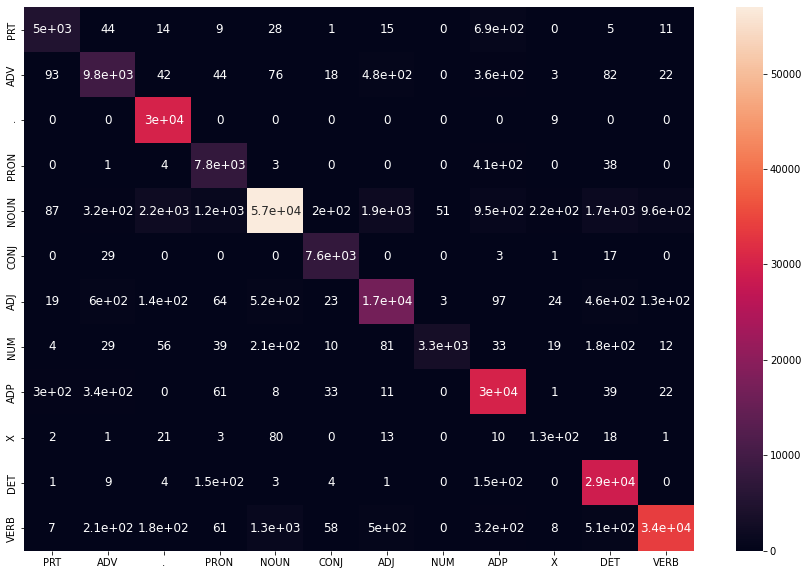

,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Precision,0.89971,0.854364,0.939137,0.845778,0.954471,0.967582,0.871586,0.982652,0.922914,0.278351,0.925124,0.970346


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Recall,0.87423,0.876382,0.999395,0.948521,0.88613,0.99132,0.885135,0.818036,0.970411,0.409091,0.991805,0.900737


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F1-score,0.886787,0.865233,0.968329,0.894208,0.919032,0.979307,0.878308,0.89282,0.946066,0.331288,0.957305,0.934247


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F0.5-score,0.894496,0.858679,0.9506,0.864507,0.939972,0.972238,0.874262,0.944634,0.932037,0.297357,0.937733,0.955577


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F2-score,0.87921,0.871888,0.986732,0.926023,0.899004,0.98648,0.882392,0.846394,0.960524,0.373961,0.977711,0.913848


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
PRT,4970.0,40.0,3.0,1.0,29.0,0.0,9.0,0.0,628.0,0.0,3.0,2.0
ADV,108.0,10542.0,56.0,44.0,84.0,31.0,553.0,0.0,488.0,0.0,86.0,37.0
.,0.0,0.0,29719.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0
PRON,0.0,2.0,0.0,8144.0,8.0,1.0,0.0,0.0,403.0,0.0,25.0,3.0
NOUN,74.0,334.0,1350.0,1006.0,53773.0,115.0,1376.0,44.0,456.0,193.0,1114.0,848.0
CONJ,0.0,47.0,0.0,1.0,0.0,8566.0,0.0,0.0,6.0,0.0,21.0,0.0
ADJ,36.0,657.0,162.0,77.0,575.0,23.0,17423.0,0.0,76.0,21.0,489.0,145.0
NUM,4.0,11.0,99.0,42.0,219.0,13.0,34.0,2549.0,24.0,32.0,86.0,3.0
ADP,331.0,453.0,4.0,66.0,16.0,30.0,13.0,1.0,31320.0,2.0,32.0,7.0
X,0.0,1.0,27.0,4.0,77.0,1.0,21.0,0.0,5.0,108.0,19.0,1.0


Weighted Precision : 0.9252227133426042
Weighted Recall : 0.9220362677744048
Weighted F1-score : 0.9217469685970849
Weighted F0.5-score : 0.9233679258782095
Weighted F2-score : 0.9214784782307253
Fold 2 :
Confusion Matrix :


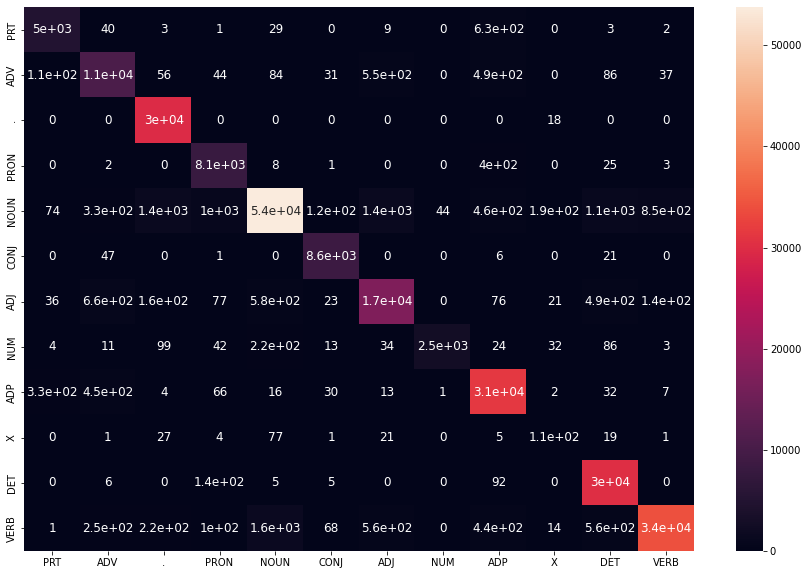

Weighted Precision : 0.9311033064432876
Weighted Recall : 0.9293130028424146
Weighted F1-score : 0.9291422789073542
Weighted F0.5-score : 0.93005915277846
Weighted F2-score : 0.9289916211109489
Fold 3 :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Precision,0.895025,0.856172,0.940488,0.835005,0.961591,0.977806,0.887005,0.975572,0.945715,0.528061,0.913728,0.973128


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Recall,0.892348,0.88418,0.999544,0.977871,0.896553,0.992917,0.877289,0.843486,0.97147,0.465169,0.990912,0.921969


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F1-score,0.893684,0.86995,0.969117,0.900809,0.927934,0.985304,0.88212,0.904734,0.95842,0.494624,0.950756,0.946858


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F0.5-score,0.894488,0.86163,0.951734,0.860138,0.947839,0.980791,0.885045,0.945946,0.950756,0.514158,0.928188,0.962447


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F2-score,0.892882,0.878433,0.987147,0.945516,0.908847,0.989857,0.879215,0.866962,0.966208,0.476519,0.974449,0.931766


Confusion Matrix :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
PRT,5073.0,54.0,4.0,6.0,13.0,2.0,6.0,0.0,519.0,0.0,3.0,5.0
ADV,81.0,10703.0,72.0,67.0,86.0,17.0,526.0,0.0,424.0,4.0,104.0,21.0
.,2.0,0.0,30706.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0
PRON,1.0,1.0,4.0,7910.0,13.0,1.0,1.0,0.0,124.0,3.0,28.0,3.0
NOUN,95.0,367.0,1281.0,1074.0,61387.0,92.0,1317.0,95.0,544.0,95.0,1339.0,784.0
CONJ,0.0,33.0,0.0,0.0,2.0,9252.0,0.0,0.0,1.0,1.0,29.0,0.0
ADJ,53.0,646.0,200.0,63.0,741.0,25.0,19303.0,0.0,110.0,17.0,702.0,143.0
NUM,11.0,32.0,121.0,45.0,209.0,1.0,54.0,3794.0,27.0,28.0,171.0,5.0
ADP,339.0,459.0,30.0,70.0,13.0,41.0,9.0,0.0,37456.0,5.0,95.0,39.0
X,6.0,8.0,23.0,10.0,87.0,4.0,20.0,0.0,22.0,207.0,28.0,30.0


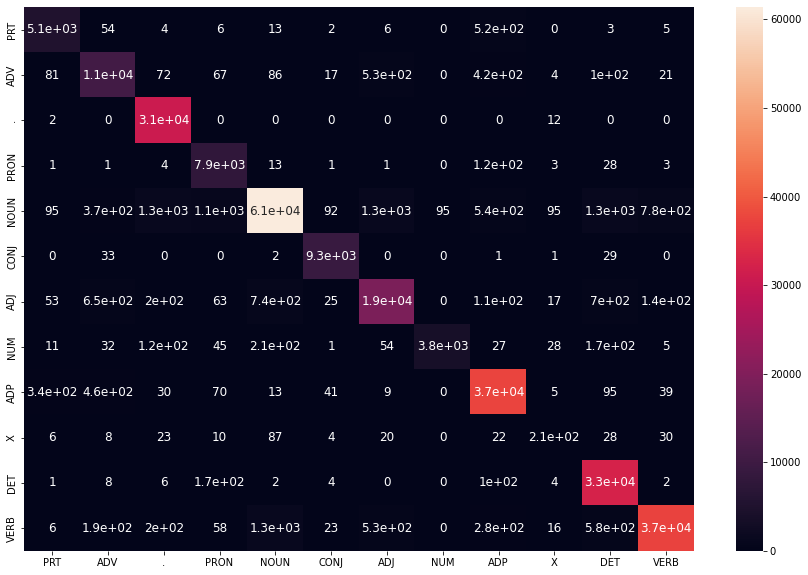

Weighted Precision : 0.9372025350372062
Weighted Recall : 0.9357536687362571
Weighted F1-score : 0.9355139787722437
Weighted F0.5-score : 0.9362973673247588
Weighted F2-score : 0.9354236984919467
Fold 4 :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Precision,0.908298,0.876516,0.950548,0.854724,0.96194,0.948319,0.856934,0.974807,0.923532,0.464286,0.934962,0.974594


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Recall,0.862551,0.887033,1.0,0.969825,0.878798,0.993594,0.884575,0.856369,0.970515,0.362791,0.983423,0.927147


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F1-score,0.884833,0.881743,0.974647,0.908644,0.918491,0.970428,0.870535,0.911758,0.946441,0.407311,0.95858,0.950278


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F0.5-score,0.898764,0.8786,0.960043,0.875505,0.944077,0.95704,0.862323,0.948569,0.932561,0.439684,0.944268,0.96472


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F2-score,0.871328,0.884909,0.989702,0.94439,0.894256,0.984196,0.878905,0.877697,0.96074,0.379377,0.973333,0.936263


Confusion Matrix :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
PRT,5309.0,65.0,23.0,29.0,48.0,11.0,5.0,0.0,646.0,0.0,10.0,9.0
ADV,179.0,9611.0,56.0,51.0,86.0,27.0,394.0,0.0,322.0,3.0,69.0,37.0
.,0.0,0.0,27910.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRON,0.0,2.0,0.0,10349.0,3.0,2.0,0.0,0.0,245.0,0.0,65.0,5.0
NOUN,86.0,272.0,968.0,1266.0,40060.0,125.0,999.0,44.0,280.0,53.0,844.0,588.0
CONJ,1.0,21.0,0.0,0.0,0.0,6514.0,0.0,0.0,3.0,0.0,17.0,0.0
ADJ,16.0,486.0,120.0,52.0,317.0,70.0,11710.0,0.0,54.0,6.0,256.0,151.0
NUM,3.0,8.0,70.0,25.0,116.0,0.0,18.0,1896.0,15.0,5.0,55.0,3.0
ADP,240.0,320.0,0.0,51.0,8.0,21.0,14.0,0.0,23732.0,3.0,19.0,45.0
X,2.0,1.0,45.0,2.0,46.0,7.0,11.0,5.0,9.0,78.0,6.0,3.0


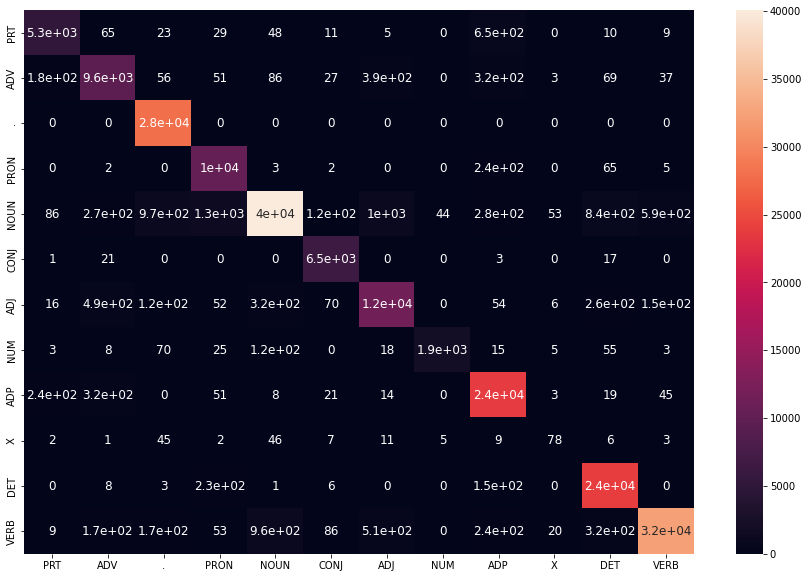

Weighted Precision : 0.9356985785800837
Weighted Recall : 0.934261089815786
Weighted F1-score : 0.9339566273204597
Weighted F0.5-score : 0.934753068856003
Weighted F2-score : 0.9338959317891503
Fold 5 :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Precision,0.872748,0.866184,0.976136,0.894656,0.956299,0.936398,0.840761,0.69745,0.905718,0.339394,0.945204,0.973719


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Recall,0.840319,0.882416,1.0,0.967934,0.864884,0.995648,0.874886,0.94403,0.957307,0.309392,0.976585,0.931684


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F1-score,0.856227,0.874224,0.987924,0.929853,0.908297,0.965114,0.857484,0.80222,0.930798,0.323699,0.960638,0.952238


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F0.5-score,0.866063,0.869382,0.980817,0.90841,0.936502,0.947677,0.847371,0.735893,0.915586,0.332937,0.951318,0.965011


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
F2-score,0.846611,0.879121,0.995134,0.952333,0.881741,0.983206,0.867841,0.881687,0.946524,0.314961,0.970143,0.939798


Confusion Matrix :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
PRT,5473.0,107.0,2.0,27.0,69.0,23.0,22.0,62.0,682.0,7.0,17.0,22.0
ADV,216.0,9088.0,37.0,31.0,107.0,42.0,398.0,20.0,253.0,6.0,41.0,60.0
.,0.0,0.0,29083.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRON,3.0,3.0,1.0,13342.0,14.0,3.0,4.0,0.0,196.0,0.0,218.0,0.0
NOUN,243.0,253.0,423.0,1155.0,29432.0,99.0,782.0,277.0,196.0,68.0,530.0,572.0
CONJ,1.0,5.0,1.0,0.0,0.0,5948.0,0.0,0.0,2.0,0.0,17.0,0.0
ADJ,6.0,462.0,64.0,47.0,267.0,63.0,8622.0,37.0,39.0,14.0,106.0,128.0
NUM,1.0,4.0,3.0,2.0,36.0,2.0,7.0,1012.0,1.0,0.0,2.0,2.0
ADP,322.0,347.0,2.0,22.0,11.0,25.0,21.0,0.0,17647.0,2.0,15.0,20.0
X,2.0,5.0,6.0,9.0,51.0,6.0,12.0,19.0,3.0,56.0,6.0,6.0


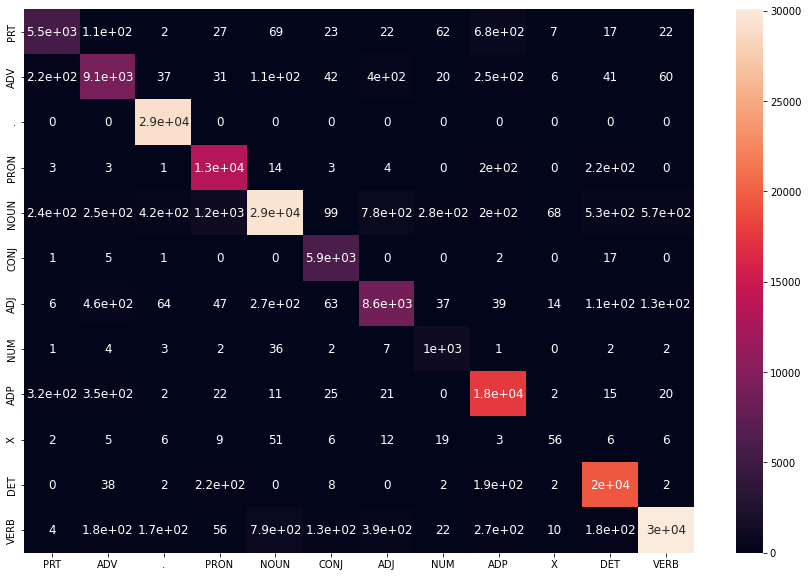

Weighted Precision : 0.934354961907106
Weighted Recall : 0.9328159254403843
Weighted F1-score : 0.9326659394647946
Weighted F0.5-score : 0.9334582659342022
Weighted F2-score : 0.9325338635715857


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Average Precision,0.896537,0.862683,0.944998,0.851317,0.959468,0.957205,0.861051,0.922878,0.921455,0.384726,0.924661,0.971791


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Average Recall,0.865812,0.883762,0.999728,0.961787,0.875831,0.993391,0.882382,0.858564,0.968678,0.403239,0.986393,0.919587


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Average F1-score,0.880831,0.873081,0.971499,0.903032,0.915665,0.974898,0.871492,0.882497,0.944433,0.386598,0.954428,0.944944


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Average F0.5-score,0.890169,0.866809,0.955402,0.871244,0.941431,0.96419,0.865175,0.9048,0.930501,0.384003,0.93632,0.960865


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
Average F2-score,0.87174,0.879455,0.988218,0.937347,0.891325,0.985894,0.877971,0.866063,0.958821,0.394401,0.973326,0.929559


Confusion Matrix :


,PRT,ADV,.,PRON,NOUN,CONJ,ADJ,NUM,ADP,X,DET,VERB
PRT,25803.0,310.0,46.0,72.0,187.0,37.0,57.0,62.0,3161.0,7.0,38.0,49.0
ADV,677.0,49695.0,263.0,237.0,439.0,135.0,2356.0,20.0,1842.0,16.0,382.0,177.0
.,2.0,0.0,147524.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0
PRON,4.0,9.0,9.0,47496.0,41.0,7.0,5.0,0.0,1375.0,3.0,374.0,11.0
NOUN,585.0,1547.0,6235.0,5699.0,241610.0,635.0,6368.0,511.0,2429.0,633.0,5555.0,3751.0
CONJ,2.0,135.0,1.0,1.0,2.0,37892.0,0.0,0.0,15.0,2.0,101.0,0.0
ADJ,130.0,2851.0,682.0,303.0,2424.0,204.0,73916.0,40.0,376.0,82.0,2018.0,695.0
NUM,23.0,84.0,349.0,153.0,786.0,26.0,194.0,12553.0,100.0,84.0,497.0,25.0
ADP,1530.0,1923.0,36.0,270.0,56.0,150.0,68.0,1.0,140386.0,13.0,200.0,133.0
X,12.0,16.0,122.0,28.0,341.0,18.0,77.0,24.0,49.0,581.0,77.0,41.0


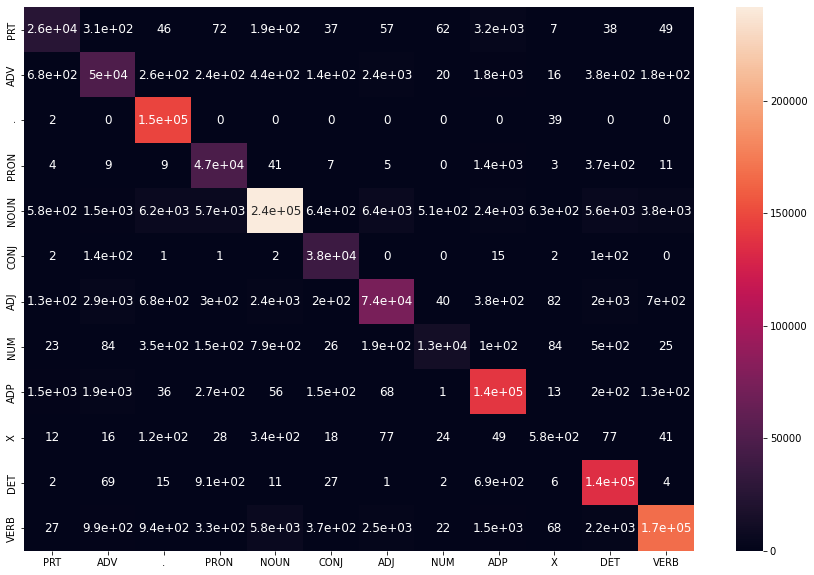

Overall average Precision : 0.9327164190620575
Overall average Recall : 0.9308359909218493
Overall average F1-score : 0.9306051586123875
Overall average F0.5-score : 0.9315871561543266
Overall average F2-score : 0.9304647186388714


In [15]:
for i in range(5):
    print("Fold", i+1, ":")
    display(pd.DataFrame(Precision[i].reshape((1, tagCount)), index = ["Precision"], columns = uniqueTags))

    display(pd.DataFrame(Recall[i].reshape(1, tagCount), index = ["Recall"], columns = uniqueTags))

    display(pd.DataFrame(F1Score[i].reshape(1, tagCount), index = ["F1-score"], columns = uniqueTags))

    display(pd.DataFrame(F05Score[i].reshape(1, tagCount), index = ["F0.5-score"], columns = uniqueTags))

    display(pd.DataFrame(F2Score[i].reshape(1, tagCount), index = ["F2-score"], columns = uniqueTags))

    print("Confusion Matrix :")
    df_cm = pd.DataFrame(ConfusionMatrix[i], index = uniqueTags, columns = uniqueTags)
    display(df_cm)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
    plt.show()

    print("Weighted Precision :", weightedPrecision[i])
    print("Weighted Recall :", weightedRecall[i])
    print("Weighted F1-score :", weightedF1Score[i])
    print("Weighted F0.5-score :", weightedF05Score[i])
    print("Weighted F2-score :", weightedF2Score[i])

avgPrecision = np.sum(Precision, axis = 0)/5
avgRecall = np.sum(Recall, axis = 0)/5
avgF1Score = np.sum(F1Score, axis = 0)/5
avgF05Score = np.sum(F05Score, axis = 0)/5
avgF2Score = np.sum(F2Score, axis = 0)/5

avgConfusionMatrix = np.zeros((tagCount, tagCount))
for i in range(5):
    avgConfusionMatrix += ConfusionMatrix[i]

display(pd.DataFrame(avgPrecision.reshape((1, tagCount)), index = ["Average Precision"], columns = uniqueTags))

display(pd.DataFrame(avgRecall.reshape(1, tagCount), index = ["Average Recall"], columns = uniqueTags))

display(pd.DataFrame(avgF1Score.reshape(1, tagCount), index = ["Average F1-score"], columns = uniqueTags))

display(pd.DataFrame(avgF05Score.reshape(1, tagCount), index = ["Average F0.5-score"], columns = uniqueTags))

display(pd.DataFrame(avgF2Score.reshape(1, tagCount), index = ["Average F2-score"], columns = uniqueTags))

print("Confusion Matrix :")
df_cm = pd.DataFrame(avgConfusionMatrix, index = uniqueTags, columns = uniqueTags)
display(df_cm)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.show()

print("Overall average Precision :", np.sum(weightedPrecision)/5)
print("Overall average Recall :", np.sum(weightedRecall)/5)
print("Overall average F1-score :", np.sum(weightedF1Score)/5)
print("Overall average F0.5-score :", np.sum(weightedF05Score)/5)
print("Overall average F2-score :", np.sum(weightedF2Score)/5)

In [17]:
allSentences = []
for i in x:
    sentence = []
    for j in i:
        sentence.append(j[0])
    allSentences.append(sentence)

In [37]:
sampleSentences = [["Praneeth", "meant", "business", "."], ["Why", "is", "the", "story", "interesting", "?"], ["I", "watched", "the", "movie", "on", "14/12", "."],
                   ["I", "bank", "my", "trust", "on", "the", "river", "ganga"], ["If", "the", "river", "was", "channelized", "properly", ", ", "the", "wheat", "cultivation", "would", "not" "have", "suffered",
                                                                                 "due", "to", "water", ""]]
outputs = viterbi(allSentences, sampleSentences)

for i in outputs:
    for j in i:
        print(uniqueTags[j], end = " ")
    print(" ", end = '\n')

[('Undergraduates', 0.21638548374176025), ('Frame', 0.2056770622730255), ('The', 0.19861841201782227), ('Parichy-Hamm', 0.16826769709587097), ('Proprietorship', 0.1520904302597046), ('its', 0.1304425746202469), ('Thyroglobulin', 0.11281665414571762), ('These', 0.10502495616674423), ('Autocollimator', 0.10104180872440338), ('An', 0.09295123815536499)]
Praneeth Undergraduates
[('Autocollimator', 0.43732333183288574), ('evident', 0.3108444809913635), ('style', 0.29577159881591797), ('true', 0.2876949906349182), ('impressive', 0.2871173024177551), ('reason', 0.28661298751831055), ('moments', 0.2857479751110077), ('male', 0.2856501638889313), ('But', 0.2842201888561249), ('exception', 0.28286245465278625)]
14/12 Autocollimator
[('series', 0.2672683894634247), ('2-4', 0.26713892817497253), ('2-3', 0.26417845487594604), ('small', 0.2630831301212311), ('variety', 0.259554386138916), ('Thirty-four', 0.24634598195552826), ('for', 0.23833435773849487), ('solid', 0.23561936616897583), ('great', 0.